### _Imports_

In [54]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model  import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

import functions as fn # importing pre-defined functions from .py file (inside notebooks folder)

### Upload diamonds train data from csv

In [55]:
diamonds_train = pd.read_csv('../data/diamonds_train.csv')
#diamonds_train.head()

**Remark**: For the diamonds dataset, we have conducted an exploratory data analysis (EDA) in advance. Find references [here](https://github.com/Kristinawk/EDA_Diamonds).  
  
This dataset doesn't have nulls, therefore we can proceed directly with encoding.

## 1. Features selection and engineering

During EDA we saw that some diamonds have ceros in size parameters x, y and z. It would be better to take these rows out for machine learning.

In [56]:
diamonds_train.describe()

,price,carat,depth,table,x,y,z
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,3928.444469,0.797706,61.752841,57.446133,5.729392,5.732819,3.537154
std,3992.416147,0.475544,1.431725,2.233535,1.124453,1.146650,0.697062
min,326.000000,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000
25%,945.000000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,2397.000000,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000
75%,5331.000000,1.040000,62.500000,59.000000,6.540000,6.540000,4.035000
max,18823.000000,4.500000,79.000000,95.000000,10.230000,58.900000,8.060000


In [57]:
len(diamonds_train.query('x == 0 or y == 0 or z == 0'))

16

In total, there are 16 rows with this issue. Lets drop these values.

In [58]:
diamonds_train.drop(diamonds_train.query('x == 0 or y == 0 or z == 0').index, inplace=True)

In [59]:
diamonds_train.describe()

,price,carat,depth,table,x,y,z
count,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000
mean,3926.535448,0.797425,61.753013,57.445543,5.729616,5.732897,3.538553
std,3990.024501,0.475257,1.431306,2.233055,1.122384,1.145002,0.693639
min,326.000000,0.200000,43.000000,43.000000,3.770000,3.720000,1.070000
25%,945.000000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,2396.000000,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000
75%,5329.500000,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000
max,18823.000000,4.500000,79.000000,95.000000,10.230000,58.900000,8.060000


### Outliers

Additionally we can do outliers analysis for these variables.

In [60]:
for col in ['x', 'y', 'z']:
    q1 = diamonds_train[col].quantile(0.25)
    q3 = diamonds_train[col].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    upper_array = np.array(diamonds_train[col] >= upper)
    lower = q1 - 1.5 * iqr
    lower_array = np.array(diamonds_train[col] <= lower)
    print(col, "Upper bound:", upper, "Lower bound:", lower)
    print(col, "Upper outliers", upper_array.sum(), "Lower outliers", lower_array.sum(), '\n')

x Upper bound: 9.285 Lower bound: 1.9649999999999999
x Upper outliers 18 Lower outliers 0 

y Upper bound: 9.27 Lower bound: 1.9899999999999993
y Upper outliers 18 Lower outliers 0 

z Upper bound: 5.734999999999999 Lower bound: 1.2150000000000003
z Upper outliers 19 Lower outliers 1 



In [61]:
len(diamonds_train.query('x > 9.28 or y > 9.27 or z > 5.73'))

27

Lets take out also these 27 rows.

In [62]:
diamonds_train.drop(diamonds_train.query('x > 9.28 or y > 9.27 or z > 5.73').index, inplace=True)

In [63]:
diamonds_train.describe()

,price,carat,depth,table,x,y,z
count,40412.000000,40412.000000,40412.000000,40412.000000,40412.000000,40412.000000,40412.000000
mean,3919.081312,0.795810,61.752643,57.444776,5.727184,5.729259,3.536927
std,3979.978307,0.471078,1.429715,2.232493,1.118725,1.110596,0.690877
min,326.000000,0.200000,43.000000,43.000000,3.770000,3.720000,1.070000
25%,945.000000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,2394.000000,0.700000,61.800000,57.000000,5.690000,5.700000,3.520000
75%,5321.000000,1.040000,62.500000,59.000000,6.540000,6.540000,4.030000
max,18823.000000,3.050000,79.000000,95.000000,9.260000,9.250000,5.730000


In our training dataset there are also outliers in price. Lets see if our model improves when we remove them.

In [64]:
for col in ['price']:
    q1 = diamonds_train[col].quantile(0.25)
    q3 = diamonds_train[col].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    upper_array = np.array(diamonds_train[col] >= upper)
    lower = q1 - 1.5 * iqr
    lower_array = np.array(diamonds_train[col] <= lower)
    print(col, "Upper bound:", upper, "Lower bound:", lower)
    print(col, "Upper outliers", upper_array.sum(), "Lower outliers", lower_array.sum(), '\n')

price Upper bound: 11885.0 Lower bound: -5619.0
price Upper outliers 2625 Lower outliers 0 



In [72]:
(len(diamonds_train[diamonds_train['price'] > 18600]) / len(diamonds_train)) *100

0.12125111353063446

In [71]:
len(diamonds_train[diamonds_train['price'] > 18600])

49

In [52]:
diamonds_train.drop(diamonds_train.query('price > 17500').index, inplace=True)

In [53]:
diamonds_train.describe()

,price,carat,depth,table,x,y,z
count,40063.000000,40063.000000,40063.000000,40063.000000,40063.000000,40063.000000,40063.000000
mean,3795.209146,0.785054,61.754844,57.439575,5.706417,5.708534,3.524308
std,3768.314204,0.458037,1.428721,2.233188,1.100533,1.092284,0.680071
min,326.000000,0.200000,43.000000,43.000000,3.770000,3.720000,1.070000
25%,942.000000,0.400000,61.000000,56.000000,4.700000,4.710000,2.900000
50%,2365.000000,0.700000,61.800000,57.000000,5.680000,5.690000,3.520000
75%,5226.000000,1.030000,62.500000,59.000000,6.520000,6.520000,4.030000
max,17496.000000,3.050000,79.000000,95.000000,9.260000,9.250000,5.730000


## 2. Encoding

### Categorical variables overview

In [15]:
cat_var_lst = ["cut", "color", "clarity"]
#cat_var_overview = fn.cat_var(diamonds_train, cat_var_lst)
#cat_var_overview

### One hot encoding

In [16]:
diamonds_train.drop('city', axis=1, inplace=True)

In [17]:
baseline_train = fn.one_hot_encod(diamonds_train, cat_var_lst)

In [18]:
baseline_train.head()

,price,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,4268,1.21,62.4,58.0,6.83,6.79,4.25,0,0,1,...,0,0,1,0,0,0,0,1,0,0
1,505,0.32,63.0,57.0,4.35,4.38,2.75,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,2686,0.71,65.5,55.0,5.62,5.53,3.65,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,738,0.41,63.8,56.0,4.68,4.72,3.00,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,4882,1.02,60.5,59.0,6.55,6.51,3.95,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [19]:
baseline_train.columns

Index(['price', 'carat', 'depth', 'table', 'x', 'y', 'z', 'cut_Good',
       'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_E', 'color_F',
       'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1',
       'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1',
       'clarity_VVS2'],
      dtype='object')

Checking that all features are numeric

In [20]:
#baseline_train.info()

### Save pre-processing to csv

In [21]:
#baseline_train.to_csv('../data/baseline_train.csv', index=False)

## 3. Model selection

In [22]:
y = baseline_train['price'].astype('float64').to_numpy()
X = baseline_train[[col for col in baseline_train.columns if col != 'price']].to_numpy()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
#print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
#print(f"X_train: {type(X_train)}, X_test: {type(X_test)}, y_train: {type(y_train)}, y_test: {type(y_test)}")

## 3. e) RandomForestRegressor

In [24]:
model_randomforest = RandomForestRegressor()

fn.cross_val(model_randomforest, X, y)

Cross val. scores: [-526.17319698 -493.77696112 -522.70011064 -486.26905527 -492.13197383] 

Mean of scores: 504.21025956621315 



## 3. g) ExtraTreesRegressor

In [25]:
model_extratrees = ExtraTreesRegressor()

fn.cross_val(model_extratrees, X, y)

Cross val. scores: [-463.68933912 -452.0432465  -463.56627734 -464.75615071 -448.10928819] 

Mean of scores: 458.43286037260003 



**CONCLUSION**: eliminating upper outliers in price improves significantly the model.

### Fit Model

In [26]:
model_extratrees.fit(X_train, y_train)
y_pred = model_extratrees.predict(X_test)

### Visual check

In [27]:
check = pd.DataFrame({'Ground truth': y_test, 'Predictions': y_pred, 'Diff': y_test - y_pred})
check

,Ground truth,Predictions,Diff
0,1436.0,1610.92,-174.92
1,780.0,778.65,1.35
2,625.0,606.60,18.40
3,3816.0,3691.89,124.11
4,6285.0,6302.00,-17.00
...,...,...,...
7833,4637.0,4763.99,-126.99
7834,1567.0,1696.08,-129.08
7835,337.0,388.79,-51.79
7836,1959.0,1625.52,333.48


In [28]:
check.reset_index(inplace=True)

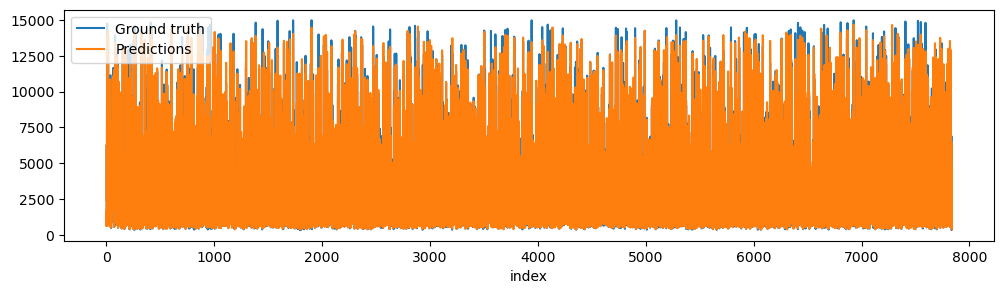

In [29]:
check.plot(x='index', y=['Ground truth', 'Predictions'], kind='line', figsize=(12, 3));

# 4. Predictions

### Upload diamonds test data from csv

In [30]:
diamonds_test = pd.read_csv('../data/diamonds_test.csv')
#diamonds_test.head()

### One-hot-encoding

In [31]:
baseline_test = fn.one_hot_encod(diamonds_test, cat_var_lst)

In [32]:
baseline_test = baseline_test[['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_Good',
       'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_E', 'color_F',
       'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1',
       'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1',
       'clarity_VVS2']]

In [33]:
#baseline_test.head()

### Predict: ExtraTreesRegressor

In [34]:
extratrees_model_pred = model_extratrees.predict(baseline_test)

C:\Users\Kristina\miniconda3\envs\sklearn_env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(


In [35]:
extratrees_model_pred

array([3048.93, 5360.04, 9338.79, ..., 3107.28, 2165.32,  864.51],
      shape=(13485,))

### Save

In [36]:
fn.save_pred(diamonds_test, extratrees_model_pred, 'encod01_featu02_model01_corrected')

'file saved succesfully'